# Exercise 1: Basic Anomaly Detection with Non-Neural Network Methods

### Goals of the exercise

- Use some basic python tools common to most machine learning and anomaly detection
- Use Covariance Estimation to Anomaly Detection on event topology
- Use an Isolation Forest to do Anomaly Detection on event topology
- Visualize our basic anomaly detection methods on real CMS Data

### Let's start out with some basic Anomaly Detection Examples.

Anomaly Detection belongs to the subfamily of machine learning disciplines called "Unsupervised Learning" (yes, there is "weakly supervised" or "semi-supervised", but in the broad three group taxonomy of "Supervised", "Unsupervised" or "Reinforcement" learning, it leans towards unsupervised). Unlike "Supervised Learning" where there is a target dataset to be replicated via the machine learning acting as a function on the data you have to the dataset you would like to predict (or reinforcement learning, which is designed to solved control and optimization problems, and targets must be learned), _"Unsupervised learning" in general, is designed to try and fit a functional form to underlying patterns of the dataset you have with no other targets_. It may help to think about it like supervised learning, but with the target being the same dataset you feed in (this is of course, not strictly true, but close enough).  

If you understand or have a good functional fit to the underlying structure of the data you are looking at, you can tell what things _do not_ fit that structure. This is anomaly detection. You may also see related or synonymous concepts "outlier detection" and "novelty detection" (as [scikit-learn puts it](https://scikit-learn.org/stable/modules/outlier_detection.html#overview-of-outlier-detection-methods), "outlier detection" is done on datasets that have outliers or anomalies mixed in, "novelty detection" learns from a dataset free from these things, and then detects anything new later)

Because neural networks have exploded in popularity over the last 10 years, nearly everyone thinks about them first when referring to machine learning (and to be fair, they are nearly an ideal use case for physics, with high expressive power, but low sample efficiency being compensated by tremendous amounts of available data to use), but neural networks are not the only machine learning tool, and certainly not the simplest. Similarly, Auto-encoders of all stripes and Generative Adversarial Networks are not the only unsupervised learning technique, or only anomaly detection technqiue. 

We're going to try a few basic tools out, just to get a sense of what anomaly detection is like without a neural network, and we'll move on to the neural network examples shortly.

First, some necessities:

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from time import perf_counter

from rich.console import Console

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

console = Console()

I have provided with this repository some h5 files with some preprocessed CMS open data in them. If you are not familiar with .h5 files, they are a simple data format that is a bit quicker than a ROOT file, but a bit less flexible. They are generally quite popular and useful for machine learning dataset purposes.

In this repo, there is a directory `/data/basic_files/` that contains .h5 files with a few different datasets in them. These are:

- `data/basic_files/ZeroBiasBasicData.h5`
  - CMS reserves some of its datastream for a random selection of events from the beam, with no preconditions. This serves several technical purposes, allowing to have some idea of what the beam is like before any trigger bias, monitoring triggger function, and giving us a chance to preserve some interesting processes we may have missed due to our biases as physicists. As you might expect, most of the things that are in this dataset are unintersting, mostly just soft QCD processes and beam pileup, but there is no reason that that interesting processes **couldn't** be in there too. This makes it an ideal dataset to go looking for anomalies in.
- `data/basic_files/JetHTBasicData.h5`
  - CMS of course, has an extensive trigger system, designed to filter the huge beam rate down into something we can actually afford to keep around as data. This task is akin to anomaly deteciton (albeit, not as unbiased as we might hope). This particualr dataset comes from the subset of triggers that trigger on jets or $H_{T}$. It will be interesting to see how our anomaly detection rates the data CMS already takes.
- `data/basic_files/TTBarBasicData.h5`
  - This is montecarlo simluation of the $t\bar{t}$ process. The discovery top quark has recently turned 30 years old, as of the writing of this, but these days, it is already a "common" signal inside LHC collider data, and we are in an era of extreme top quark precision measurements. This sample will serve as a good benchmark about how well AD helps us find some common things we know are are signals.
- `data/basic_files/SoftQCDBasicData.h5`
  - CMS maintains specific simulation that is designed to simulated beam background and pile-up... but unfortunately I couldn't find any in the format I need. This will serve as a next best thing. We can use this to try and gauge the extent to which our AD is just picking up the differences between MC and actual data
- `data/basic_files/RadionBasicData.h5`
  - This is an exotic signal I picked at random. It is "GluGluToRadionToHHTo2B2ZTo2L2J". Needless to say, quite exotic, but the kind of thing that AD would be searching for.
 
The actual data recorded in these files is quite basic. In order, per event I have, the number of reconstructed jets, the number of reconstructed muons, the number of reconstructed electrons, then photons, taus, wide jets, boosted taus, then the event recorded MET. These are just some basic variables for looking at event topology, we could add additional things (and indeed will later), but they will do for now.

List by index for convenience, the features I have provided are:

0. nJets
1. nMuons
2. nElectrons
3. nPhotons
4. nTaus
5. nWideJets
6. nBoostedTaus
7. Event MET

Let's start by getting this data prepared, and taking a look at it.:


In [2]:
def load_data(file_path: str) -> np.array:
    with h5py.File(file_path) as the_file:
        data = np.array(the_file['basic_event_data'])
    return data

zerobias_data = load_data('data/basic_files/ZeroBiasBasicData.h5')

console.print(zerobias_data.shape)

jetht_data = load_data('data/basic_files/JetHTBasicData.h5')

console.print(jetht_data.shape)

ttbar_data = load_data('data/basic_files/TTBarBasicData.h5')

console.print(ttbar_data.shape)

softqcd_data = load_data('data/basic_files/SoftQCDBasicData.h5')

console.print(softqcd_data.shape)

radion_data = load_data('data/basic_files/RadionBasicData.h5')

console.print(radion_data.shape)

(802344, 8)

(248737, 8)

(2415772, 8)

(386000, 8)

(1000, 8)

(I find it good practice when working with numpy data, and preparing for machine learning tasks to print out the shape of the data I am working with, just so there are no mistakes)

Alright. This is where you start coming in. Let's take a look at what this data looks like (also a good practice before doing machine learning stuff). Lets make a few 1D histograms and scatter plots of how objects are distributed in zero bias data. I have included `matplotlib` for this purpose. If you, like me, are a relative newcomer to matplotlib over ROOT, I'll leave these links here:

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html

and give you a couple basic examples.

(yeah, you could get ChatGPT to do this, or even google's search AI, and I'm not going to tell you not to use these tools, but I want to stress the difference between getting some LLM to teach you the basics, teach what you would need to go look up, giving you a skeleton to expand upon and helping you to do it for yourself, and just getting the LLM to do things for you. You do learn differently in those two cases).


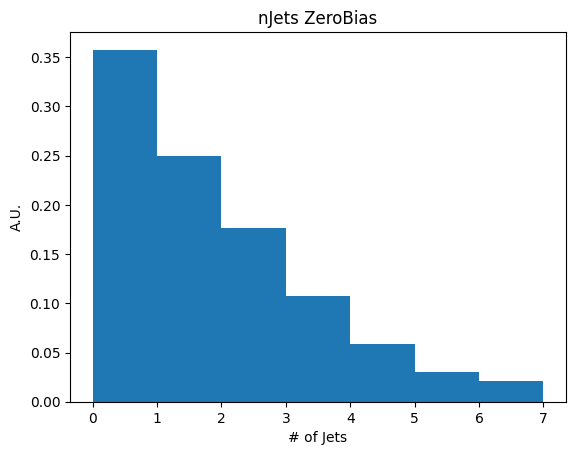

<Figure size 640x480 with 0 Axes>

In [3]:
plt.hist(
    zerobias_data[:, 0],
    bins=7,
    range=(0,7),
    density=True,
    histtype='stepfilled'
)
plt.xlabel("# of Jets")
plt.ylabel("A.U.")
plt.title("nJets ZeroBias")
plt.show()
plt.clf()

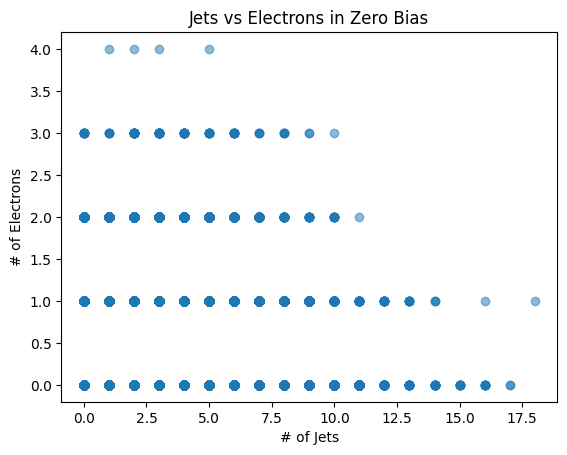

<Figure size 640x480 with 0 Axes>

In [4]:
plt.scatter(
    zerobias_data[:, 0],
    zerobias_data[:, 1],
    alpha=0.5
)

plt.xlabel("# of Jets")
plt.ylabel("# of Electrons")
plt.title("Jets vs Electrons in Zero Bias")
plt.show()
plt.clf()

Play around a bit, get a feel for how the variables are related, or aren't (you could probably write a couple of helper functions to cut down on the amount of code you have to write):

In [5]:
#
# Exercise: Make some plots of Zero Bias Data
#

Okay. Now let's do some machine learning.

### Basic AD:  Covariance Estimation

One of the simplest methods for doing anomaly detection relies on estimating the variance/covariance of data. This is a reasonable enough approximation, as the Gaussian Normal Distribution is of course an _incredibly_ common way to find data distributed for complex or inherently probabilistic systems. The idea is simple enough and should sound a little familiar, assume/fit a normal distribution to the data, and things far enough outside the boundary defined by the standard deviation (technically in this case, the Mahalannobis Distance) are outliers. But there is a slight twist. Outliers/anomalies tend to have an outsized effect on the covariance estimation. To get around it, a reduced set of data, with conditions on the covariance matrix, is used (Minimum Covariance Determinant) to get a more robust estimation of what the covariance for the most central set of data looks like.

You're going to try it out. Make an sklearn pipeline, and fit it to our zero bias data. [Here's the scikit-learn page for the EllipticEnvelope](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope)

To help out with the fit (it can be a bit unstable due to the high number of points), I [split the zero bias data into a train set](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) of about 1/8th of the data and a test set of about 7/8ths of it

(A few hints: 

It is always good practice to normalize all your data before doing model fitting!

The fit is a little picky due to the high number of points it is using to do matrix math/covariance estimation. If it gives you tons of warnings the fit likely broke. Set the `support_fraction` a bit higher in the `EllipticEnvelope` declaration. This uses more points in the covariance estimation, and makes it a touch easier for anomalies to be included in the covariance estimation, but it helps the fit out. Start with `support_fraction=0.6`

The elliptic envelope has a hyperparameter! `contamination`, the amount of expected anomalies. Try playing around with it!

If you have extra time, try playing around with other preprocessing ideas, like PCA. I haven't tested it, but it might be interesting

)

In [6]:
from sklearn.covariance import EllipticEnvelope
from sklearn.model_selection import train_test_split

zerobias_train, zerobias_test = train_test_split(
    zerobias_data,
    train_size= (100000)/len(zerobias_data),
    random_state=42,
)

In [7]:
#
# Exercise: Make a covariance envelope estimator
#


covariance_model = Pipeline(
    [
        (
            "normalization",
            StandardScaler()
        ),
        (
            "covariance_AD",
            EllipticEnvelope(
                #assume_centered=True,
                support_fraction=0.6,
                contamination=0.1, #Tunable hyper-parameter!
                random_state=123
            )
        )
    ]
)
# I am not making an effort to split this into a train_test set, although, you could do that, and indeed it might be good to do so.
start_fit = perf_counter()
covariance_model.fit(zerobias_train)
end_fit = perf_counter()
console.print(f'Completed fit in: {end_fit-start_fit:0.2g} Seconds')

/afs/hep.wisc.edu/cms/aloeliger/anomalyTriggerWork/ADWorkshop/CMS_OpenData_Exercises/cms_opendata_exercises_env/lib64/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:185: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-263.603975003995970 > -642.970437095709599). You may want to try with a higher value of support_fraction (current value: 0.600).
  warnings.warn(


Completed fit in: 3.2 Seconds

In [8]:
covariance_model

Pipeline(steps=[('normalization', StandardScaler()),
                ('covariance_AD',
                 EllipticEnvelope(random_state=123, support_fraction=0.6))])

Great, Now we have a model for anomalous data in the CMS beam! What does that look like? Let's predict which of our events are anomalous, and figure out where they are!

(
A few hints and things to check out:

We set the amount of anomlies we expected to see as a hyper-parameter. Did we actually get that much when we predict on zero bias data?

Look at the anomalies as a histogram in nJets first (two histograms, with alpha = 0.5). Any features that stick out to you?
)

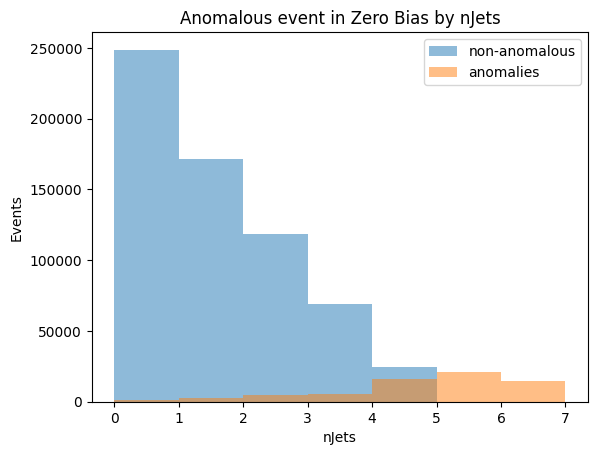

<Figure size 640x480 with 0 Axes>

In [9]:
#
# Exercise: Make predictions on our zero bias dataset and plot the events that are anomalous
#
zerobias_covariance_anomaly_mask = covariance_model.predict(zerobias_test)
zerobias_covariance_nonanomalies = zerobias_test[zerobias_covariance_anomaly_mask == 1]
zerobias_covariance_anomalies = zerobias_test[zerobias_covariance_anomaly_mask == -1]

#console.print(len(zerobias_covariance_anomalies)/len(zerobias_data))
#console.print(len(zerobias_data))

plt.hist(
    zerobias_covariance_nonanomalies[:, 0],
    bins=7,
    range=(0,7),
    histtype='stepfilled',
    alpha=0.5,
    label='non-anomalous',
)

plt.hist(
    zerobias_covariance_anomalies[:, 0],
    bins=7,
    range=(0,7),
    histtype='stepfilled',
    alpha=0.5,
    label='anomalies',
)

plt.xlabel('nJets')
plt.ylabel('Events')
plt.title('Anomalous event in Zero Bias by nJets')
plt.legend(loc='upper right')
plt.show()
plt.clf()


Here's an advanced challenge, feel free to skip it, but see if you draw out the 2D decision boundaries as [shown here](https://scikit-learn.org/stable/auto_examples/covariance/plot_mahalanobis_distances.html#sphx-glr-auto-examples-covariance-plot-mahalanobis-distances-py) for the numbers jets and MET, and number of jets and number of electrons.

It doesn't seem to work very well because we've fit our model on more than 2 variables. Many things that are non-anomalous in jets or MET, end up anomalous for other reasons. You can try to offset integer variables for the non-anomalous plot just slightly to get a better picture.

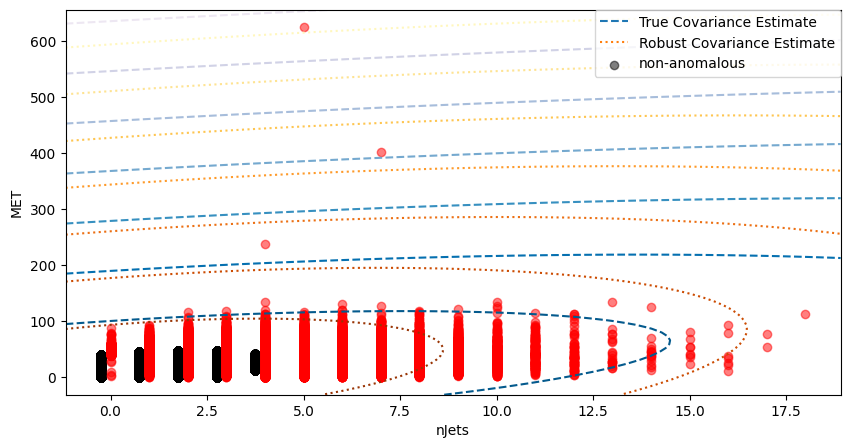

In [10]:
#
# Optional Exercise: Plot decision function curves for a few combinations of variables
#

import matplotlib.lines as mlines
from sklearn.covariance import EmpiricalCovariance, MinCovDet

emp_cov = EmpiricalCovariance()
min_cov = MinCovDet()

emp_cov.fit(np.stack([zerobias_test[:, 0], zerobias_test[:, 7]], axis=1))
min_cov.fit(np.stack([zerobias_test[:, 0], zerobias_test[:, 7]], axis=1))

fig, ax = plt.subplots(figsize=(10, 5))

non_anomalous_plot = plt.scatter(
    zerobias_covariance_nonanomalies[:, 0]-0.25,
    zerobias_covariance_nonanomalies[:, 7],
    color='black',
    alpha=0.5,
    label='Non-anomalous'
)

anomalous_plot = plt.scatter(
    zerobias_covariance_anomalies[:, 0],
    zerobias_covariance_anomalies[:, 7],
    color='red',
    alpha=0.5,
    label='Anomalies'
)

#Make the mesh grid
xx, yy = np.meshgrid(
    np.linspace(plt.xlim()[0], plt.xlim()[1], 100),
    np.linspace(plt.ylim()[0], plt.ylim()[1], 100),
)

zz = np.c_[xx.ravel(), yy.ravel()]

# Calculate the MLE based Mahalanobis distances of the meshgrid
mahal_emp_cov = emp_cov.mahalanobis(zz)
mahal_emp_cov = mahal_emp_cov.reshape(xx.shape)
emp_cov_contour = plt.contour(
    xx, yy, np.sqrt(mahal_emp_cov), cmap=plt.cm.PuBu_r, linestyles="dashed"
)
# Calculate the MCD based Mahalanobis distances
mahal_robust_cov = min_cov.mahalanobis(zz)
mahal_robust_cov = mahal_robust_cov.reshape(xx.shape)
robust_contour = ax.contour(
    xx, yy, np.sqrt(mahal_robust_cov), cmap=plt.cm.YlOrBr_r, linestyles="dotted"
)

ax.legend(
    [
        mlines.Line2D([], [], color="tab:blue", linestyle="dashed"),
        mlines.Line2D([], [], color="tab:orange", linestyle="dotted"),
        non_anomalous_plot,
        #anomalous_plot,
    ],
    [
        "True Covariance Estimate", 
        "Robust Covariance Estimate", 
        "non-anomalous", 
        "anomalous"
    ],
    loc="upper right",
    borderaxespad=0,
)

ax.set_xlabel('nJets')
ax.set_ylabel('MET')
plt.show()

As I mentioned above, a great deal of effort already goes into doing a kind of anomaly detection on the LHC beam as it goes into CMS. That's the whole job of the trigger system. We have to narrow down a ~28 MHz rate to a few kHz we can actually save. How does our anomaly detection compare to anomaly detection already done? Well, let's make predictions on that data. Do we find it anomalous? First, try just figuring out how many events in the data set are rated anomalous (as a percentage)

In [11]:
#
# Exercise: Figure out what percent of the Jet HT dataset is anomalous in the covariance model
#

jetht_covariance_anomaly_mask = covariance_model.predict(jetht_data)

jetht_anomalies = jetht_data[jetht_covariance_anomaly_mask == -1]
jetht_nonanomalies = jetht_data[jetht_covariance_anomaly_mask == 1]

console.print(f'The Jet HT dataset is: {len(jetht_anomalies)/len(jetht_data):0.2%} anomalies according to our zero bias model')

The Jet HT dataset is: 87.48% anomalies according to our zero bias model

This is interesting, but remember how we set an amount of anomalies we wanted to see before? We could keep retesting this for any number of hyper-parameters...

Remember, that anomaly detection is attempting to make an unsupervised classifier (in effect) though! We can talk about like a classifier (between anomalous and not), and use metrics that are common to supervised classifiers! In this case, the ROC curve (Receiver Oeprating Characteristic if you are not familiar, a curve/metric that basically asks, for a given score, how much of my signal do I get versus how much of my background do I let in, the goal being maximum signal for minimum background, typically denoted as AUC, Area-Under-the-Curve, with higher being better). ROCs really need a score per sample to be used though, so what do we use? Well, the elliptic curve provides a method `score_samples()` that it uses to generate scores (based on the Mahalanobis distances) it cuts on for the hyperparameter we set earlier. We can just get direct scores, and use that as our score per sample (it actually returns the negative, so we just add another negative sign).

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score

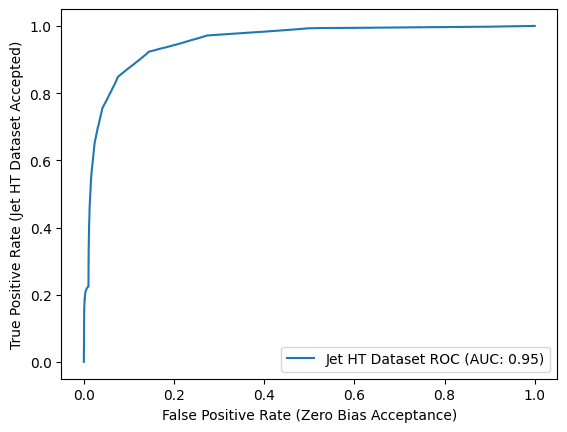

In [13]:
#
# Exercise: Make a ROC curve of Jet HT versus Zero Bias
#

jetht_score = -1.0*covariance_model.score_samples(jetht_data)
zerobias_score = -1.0*covariance_model.score_samples(zerobias_train)

y_true = np.append(
    np.ones(len(jetht_score)),
    np.zeros(len(zerobias_score)),
    axis=0,
)
y_pred=np.append(
    jetht_score,
    zerobias_score,
    axis=0
)

fpr, tpr, _ = roc_curve(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

plt.plot(
    fpr,
    tpr,
    label=f'Jet HT Dataset ROC (AUC: {auc:.2})'
)
plt.xlabel('False Positive Rate (Zero Bias Acceptance)')
plt.ylabel('True Positive Rate (Jet HT Dataset Accepted)')
plt.legend()


Not bad huh? Just some math about distribution variance and we're already selecting the better part of an interesting physics dataset making **no** assumptions other than we think most beam events are pretty uninteresting.

There's a lot of cool things about this method already. For one, it is so simple, with a bit of work, it could be implemented just about anywhere, even in HLS on an FPGA if you were so inclined. There's a lot of other things we could discuss about this, and I plan to, but let's introduce another Anomaly detection type first and then talk about the various points we should note.

### Basic AD: Isolation Forest

Another simple model you can use to look for anomalies is an "Isolation Forest". The idea behind this goes like so: imagine a scatterplot of a 2D dataset with some outliers. The non-outliers in that dataset are, by definition, going to closer to themselves, and relatively tightly packed in compared to the outliers. Now imagine splitting the dataset in two with a random cut along one variable/axis. If you keep cutting the dataset, it takes far fewer cuts to isolate an anomalous data point away, than one of the non-anomalous ones, because of the different densities. The number of cuts (or path length along the tree of cuts) is different for anomalies and non-anomalies, giving us a way to rank the anomalous-ness of a data-point and separate them. This can be done over many random trees to produce a generalized anomaly model of our data. This type of model with many trees is our "Isolation Forset" (this is highly related to the decision tree series of models that are still popular, and it's ensemble equivalents, the random forest).

[Here's a link to the scikit-learn API](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest). You're going to make one.

(A few hints, things to look at:

Scale your data!

the isolation forest has a `contamination` hyperparameter also. It also has an 'auto' method, based on it's original paper. I recommend setting it to 0.05 by hand.

like random forests/most ensemble models, isolation forests have a hyperparameter including the number of base estimators `n_estimators`. Try playing around with that

I find forest/tree techniques depend _heavily_ on preprocessing and especially choice of input features. Try playing around with that)

In [14]:
from sklearn.ensemble import IsolationForest

#We can use a slightly bigger set of training data here
zerobias_train, zerobias_test = train_test_split(
    zerobias_data,
    test_size= 0.4,
    random_state=42,
)

In [15]:
#
# Exercise: Make an Isolation forest Anomaly Detection Model
#

isoforest_model = Pipeline(
    [
        (
            'scaler',
            StandardScaler()
        ),
        (
            'isolation_forest',
            IsolationForest(
                contamination=0.05,
                n_estimators=100, # Hyperparameter!
            )
        )
    ]
)

start_fit = perf_counter()
isoforest_model.fit(zerobias_train)
end_fit = perf_counter()
console.print(f'Completed fit in: {end_fit-start_fit:0.2g} Seconds')

Completed fit in: 2 Seconds

As before, let's take a look at what events are anomalous. For variety's sake, let's look at nElectrons and MET

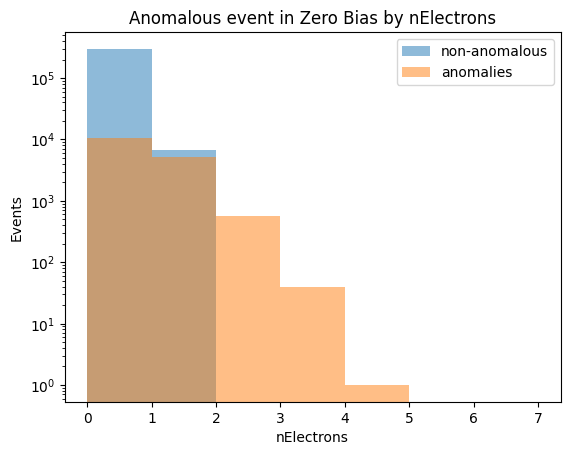

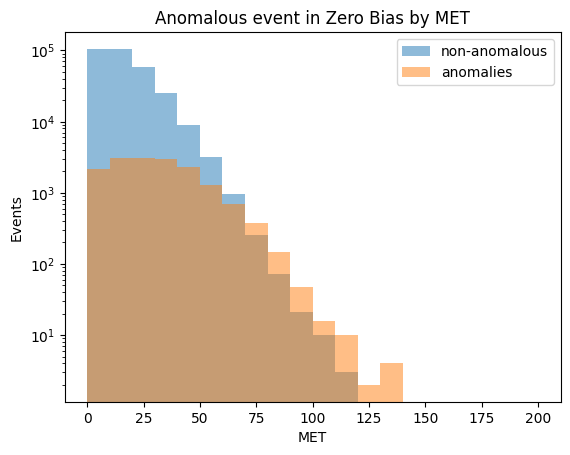

<Figure size 640x480 with 0 Axes>

In [16]:
zerobias_isoforest_anomaly_mask = isoforest_model.predict(zerobias_test)
zerobias_isoforest_nonanomalies = zerobias_test[zerobias_isoforest_anomaly_mask == 1]
zerobias_isoforest_anomalies = zerobias_test[zerobias_isoforest_anomaly_mask == -1]

plt.hist(
    zerobias_isoforest_nonanomalies[:, 2],
    bins=7,
    range=(0,7),
    histtype='stepfilled',
    alpha=0.5,
    label='non-anomalous',
)

plt.hist(
    zerobias_isoforest_anomalies[:, 2],
    bins=7,
    range=(0,7),
    histtype='stepfilled',
    alpha=0.5,
    label='anomalies',
)

plt.xlabel('nElectrons')
plt.ylabel('Events')
plt.yscale('log')
plt.title('Anomalous event in Zero Bias by nElectrons')
plt.legend(loc='upper right')
plt.show()
plt.clf()

plt.hist(
    zerobias_isoforest_nonanomalies[:, 7],
    bins=20,
    range=(0,200),
    histtype='stepfilled',
    alpha=0.5,
    label='non-anomalous',
)

plt.hist(
    zerobias_isoforest_anomalies[:, 7],
    bins=20,
    range=(0,200),
    histtype='stepfilled',
    alpha=0.5,
    label='anomalies',
)

plt.xlabel('MET')
plt.ylabel('Events')
plt.yscale('log')
plt.title('Anomalous event in Zero Bias by MET')
plt.legend(loc='upper right')
plt.show()
plt.clf()

A thing we haven't done yet is take a look at how well our Anomaly detection can find signals, things that could be new physics. Now, we should be a bit careful here that we don't introduce bias into our evaluation of models by tuning them for specific signals (or training a supervised model to find one!) but we can ask how well our models do. Our stand-in here will be the $t\bar{t}$ process. As before, let's take a look at ROC curves on the Jet HT set, and the $t\bar{t}$ data. You can use `score_samples` again (in this case, it is doing math on the path length to the leaf containing an observation, but has adjusted it so high score is high anomalousness). 

[0.71052449 0.78276383 0.68704741 ... 0.82518266 0.80805538 0.75164958]
[0.66854713 0.67601708 0.64659915 ... 0.79546654 0.77161244 0.76496272]
[0.36195792 0.36042513 0.35796536 ... 0.5863441  0.42923039 0.41794414]


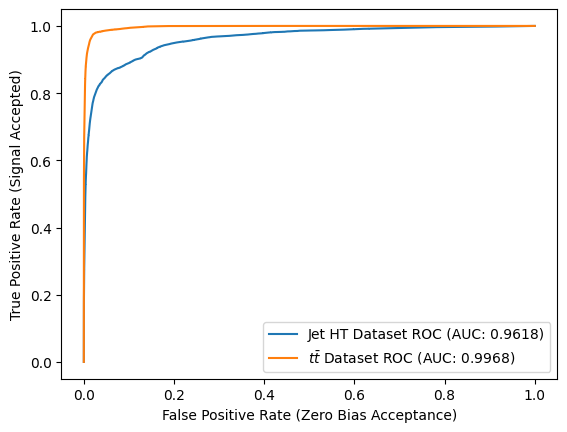

In [17]:
#
# Exercise: Make a ROC curve on the Jet HT set and ttbar set with respect to zero bias
#

ttbar_score = -1.0*isoforest_model.score_samples(ttbar_data)
jetht_score = -1.0*isoforest_model.score_samples(jetht_data)
zerobias_score = -1.0*isoforest_model.score_samples(zerobias_train)

print(ttbar_score)
print(jetht_score)
print(zerobias_score)

y_true = np.append(
    np.ones(len(jetht_score)),
    np.zeros(len(zerobias_score)),
    axis=0,
)
y_pred=np.append(
    jetht_score,
    zerobias_score,
    axis=0
)

fpr, tpr, _ = roc_curve(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

plt.plot(
    fpr,
    tpr,
    label=f'Jet HT Dataset ROC (AUC: {auc:.4})'
)

y_true = np.append(
    np.ones(len(ttbar_score)),
    np.zeros(len(zerobias_score)),
    axis=0,
)
y_pred=np.append(
    ttbar_score,
    zerobias_score,
    axis=0
)

fpr, tpr, _ = roc_curve(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

plt.plot(
    fpr,
    tpr,
    label=r'$t\bar{t}$ Dataset ROC ' +f'(AUC: {auc:.4})'
)

plt.xlabel('False Positive Rate (Zero Bias Acceptance)')
plt.ylabel('True Positive Rate (Signal Accepted)')
plt.legend()

You should find that we're doing pretty good again! In fact, just based on the AUC for Jet HT, we are probably doing _better_ than the covariance based methods (likely due to a slightly more accurate to the underlying distribution fit than just assuming everything is normally distributed).

And on the $t\bar{t}$ signal you should find we do incredibly well!

Another thing we could ask is, "How well does this method do over existing triggering methods?". We can make our roc curve against the Jet HT dataset instead

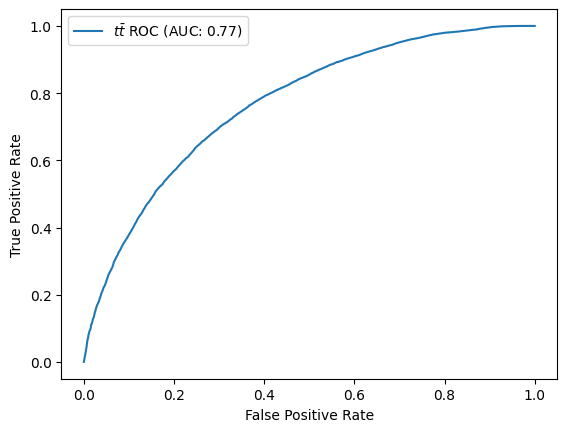

In [18]:
#
# Exercise: make a ttbar ROC curve with respect to the Jet HT set
#

y_true = np.append(
    np.ones(len(ttbar_score)),
    np.zeros(len(jetht_score)),
    axis=0,
)
y_pred=np.append(
    ttbar_score,
    jetht_score,
    axis=0
)

fpr, tpr, _ = roc_curve(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

plt.plot(
    fpr,
    tpr,
    label=r'$t\bar{t}$'+f' ROC (AUC: {auc:.2})'
)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

This isn't even half bad at finding $t\bar{t}$ in a very specifically jet selected dataset!

One of the upsides of this minimally biased, unsupervised technique is that it is maximally applicable. We can potentially use it to find _any_ signal. To demonstrate, let's make a ROC curve wtih the Radion sample and $t\bar{t}$ sample.

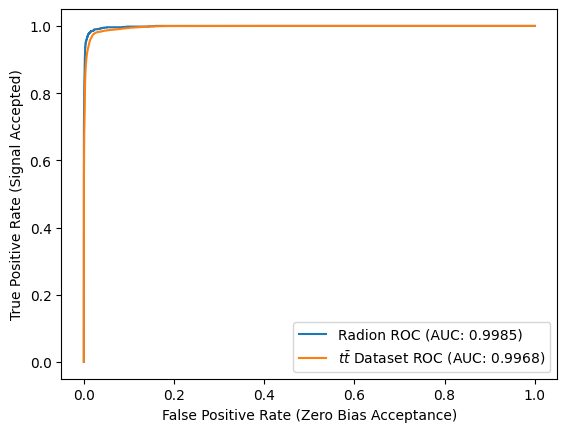

In [19]:
#
# Exercise: Make two ROC curves, ttbar and radion, with zero bias as background
#
radion_score = -1.0*isoforest_model.score_samples(radion_data)

y_true = np.append(
    np.ones(len(radion_score)),
    np.zeros(len(zerobias_score)),
    axis=0,
)
y_pred=np.append(
    radion_score,
    zerobias_score,
    axis=0
)

fpr, tpr, _ = roc_curve(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

plt.plot(
    fpr,
    tpr,
    label=f'Radion ROC (AUC: {auc:.4})'
)

y_true = np.append(
    np.ones(len(ttbar_score)),
    np.zeros(len(zerobias_score)),
    axis=0,
)
y_pred=np.append(
    ttbar_score,
    zerobias_score,
    axis=0
)

fpr, tpr, _ = roc_curve(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

plt.plot(
    fpr,
    tpr,
    label=r'$t\bar{t}$ Dataset ROC ' +f'(AUC: {auc:.4})'
)

plt.xlabel('False Positive Rate (Zero Bias Acceptance)')
plt.ylabel('True Positive Rate (Signal Accepted)')
plt.legend()

But here's the complication. We've been evaluating our MC performance against data. It's possible our model is just picking up on the difference between data and MC, not the difference between uninteresting events and exciting physics. This is why I have included the Soft QCD dataset. It isn't a perfect stand in for the beam background simulation, but it should give us an idea how much of our signal finding power is just a function of Data and MC looking kind of different anyways.

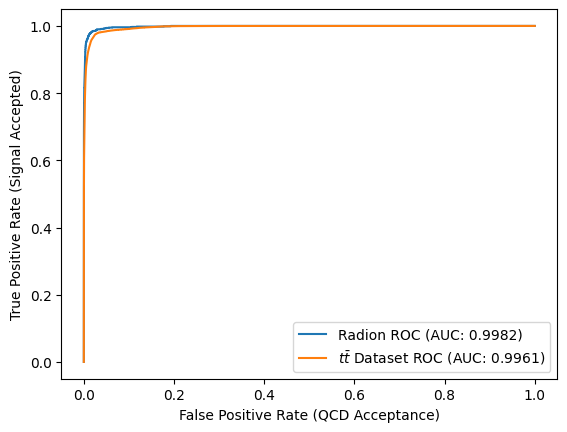

In [20]:
#
# Exercise: Make a ROC curve of the ttbar dataset and Radion set with respect to the soft QCD set
#

qcd_score = -1.0*isoforest_model.score_samples(softqcd_data)

y_true = np.append(
    np.ones(len(radion_score)),
    np.zeros(len(qcd_score)),
    axis=0,
)
y_pred=np.append(
    radion_score,
    qcd_score,
    axis=0
)

fpr, tpr, _ = roc_curve(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

plt.plot(
    fpr,
    tpr,
    label=f'Radion ROC (AUC: {auc:.4})'
)

y_true = np.append(
    np.ones(len(ttbar_score)),
    np.zeros(len(qcd_score)),
    axis=0,
)
y_pred=np.append(
    ttbar_score,
    qcd_score,
    axis=0
)

fpr, tpr, _ = roc_curve(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

plt.plot(
    fpr,
    tpr,
    label=r'$t\bar{t}$ Dataset ROC ' +f'(AUC: {auc:.4})'
)

plt.xlabel('False Positive Rate (QCD Acceptance)')
plt.ylabel('True Positive Rate (Signal Accepted)')
plt.legend()

You should find that we're still doing okay, but the performance is just a touch worse than when we evaluated against data. If we had proper simulation of the beam background available, I would expect it to still be a pretty good method, but maybe not as good as we see here, picking up a bit on the difference between simulation and true data.

### Wrap-up

There's a lot of cool stuff in AD and basic data-science style anomaly detection that I just won't have time to get all the way into. I highly recommend taking a read through of SciKit-Learn's [Outlier and Novelty Detection](https://scikit-learn.org/stable/modules/outlier_detection.html#id1) section to get a sense of what sort of things are out there. If you can get away with not using a neural network for simplicity reasons, or a neural network just doesn't out-perform the simple stuff, you should be aware that these techniques are out there.

That being said, I love some neural network techniques, and I'm willing to bet you want to see some too. Let's talk about them in the next exercise